## Peebles-Ratra model, Metropolis-Hastings implementation
### Pantheon + BAO + Cosmic cronometers
___

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Obtaining scale parameter vector
var_a = []
step_a = []
a0 = pow(10.,-6)
var_a.append(a0)
while a0<=1.:
    z = 1./a0 -1.
    if z>pow(10,-1):
        a1 = a0*(1. + 1./10000.)
        var_a.append(a1)
        step_a.append(a0/10000.)
        a0 = a1
    else:
        a1 = a0*(1. + 1./1000000.)
        var_a.append(a1)
        step_a.append(a0/1000000.)
        a0 = a1
# Only values that fulfill a<1.
var_a = np.array(var_a[:-1])
var_z = 1/var_a -1 # redshift list

print(min(var_a),max(var_a))

1e-06 0.9999993951114841


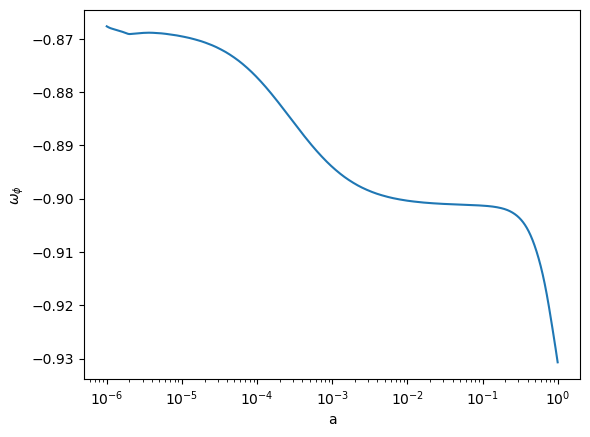

In [3]:
from scipy.integrate import solve_ivp

# Parameters
c = 299792.458 #km/s
w_r = 2.469*10**(-5) #Amendola pag 15
z_star = 1089.92

# Best parameters from 
M = -19.253 # SN absolute magnitude
w_m = 0.1403 #arXiv:1610.08965
k = 32.5*pow(10,3) #arXiv:1610.08965
alpha = 0.219 #arXiv:1610.08965

# Solving the differential equation sistem
def fun(a,y):
    H = np.sqrt(np.abs((k*pow(y[0],-alpha)+1.2*pow(10.,5)*
                        (w_m*pow(a,-3)+w_r*pow(a,-4)))/(12-pow(a*y[1],2))))
    dH = -(3./(2*a*H))*(pow(a*H*y[1],2)/6. + pow(10.,4)*
                        (w_m*pow(a,-3)+(4./3.)*w_r*pow(a,-4)))
    f = np.zeros(2,dtype=np.float64)
    f[0]=y[1]
    f[1]=-(4./a + dH/H)*y[1] + (alpha*0.5*k*pow(y[0],-(alpha+1)))/pow(a*H,2)
    return f

# Initial values
a_ini = pow(10,-6)
a_fin = 1.

phi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4),
          1./(alpha+2.))
dphi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4.-alpha-2.),
          1./(alpha+2.))*4./(alpha+2.)

# Scipy solver
sol = solve_ivp(fun, [a_ini, a_fin], [phi, dphi], t_eval=var_a)

# Some usefull lists (values for all evolution)
phis = np.array(sol.y.T[:,0]) # scalar field
dphis = np.array(sol.y.T[:,1]) # scalar field proper time derivative
Mpl = 1.22*10**19 # Planck mass
V = (1/2)*k*(phis**(-alpha)) # potential for every a value
Hs = np.sqrt(np.abs((k*pow(phis,-alpha)+1.2*pow(10.,5)*
                     (w_m*pow(var_a,-3)+w_r*pow(var_a,-4)))/(12-pow(var_a*dphis,2)))) # H(a) for every a

phipunts = var_a*Hs*dphis # scalar field time derivative
rho = ((Mpl**2)/(16*np.pi))*((phipunts**2)/2 + V) # scalar field energy density
p = ((Mpl**2)/(16*np.pi))*((phipunts**2)/2 - V) # scalar field pressure
wphi = p/rho # equation of state parameter for scalar field

plt.figure()

plt.plot(var_a, wphi)
plt.semilogx()
plt.xlabel('a')
plt.ylabel('$\omega_\phi$')
plt.show()

In [4]:
print('H0 value:',Hs[-1],',','wphi(z=0):', wphi[-1])

H0 value: 67.14444025257478 , wphi(z=0): -0.9307155652587823


In [5]:
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

# Parameters
c = 299792.458 #km/s
w_r = 2.469*10**(-5) #Amendola pag 15
z_star = 1089.92

# Best parameters from arXiv:1610.08965
M = -19.253
w_m = 0.1403
k = 32.5*pow(10,3)
alpha = 0.219

def H(z):
    dist = np.abs(var_z-z)
    return Hs[np.nonzero(dist == dist.min())[0][0]]

def frac_H(z):
    dist = np.abs(var_z-z)
    return 1./Hs[np.nonzero(dist == dist.min())[0][0]]

def integrate_frac_H(z_lim):
    idx = ((var_z<z_lim)==0).sum()
    z_int = var_z[idx:]
    frac_H_int = 1./(Hs[idx:])
    integral = (z_int[1:]-z_int[:-1])*(frac_H_int[1:]+frac_H_int[:-1])*0.5
    return np.abs(integral.sum())

# And a function that calculates m_th depending if the galaxy is host or not
def host_select(row):
    if row['host']==0: #no host, we use our values of H(z)
        #integral = sp.integrate.quad(frac_H,0.,row['z_hel'])[0] # element 1 is error
        integral = integrate_frac_H(row['z_hel'])
        m_th = M + 25. + 5.*np.log10(c*(1+row['z_hel'])*integral)
        # c must be in km/s in order to compensate H adimensionalisation
        return m_th
    if row['host']==1: #host, we use cepheids
        m_th = M + row['mu']
        return m_th
    
# A function that calculates H given z and aplies it to dataframe
def H_theo(row):
    return H(row['z'])

# A function that calculates the theorical values for BAO columns
def BAOs(row):
    idx = row.name # we obtain the index of the actual row
    if idx==0:
        # D_M(z_*), z_* = 1089.92
        #integral = sp.integrate.quad(frac_H,0.,z_star)[0]
        integral = integrate_frac_H(z_star)
        return c*integral*10**(-3) # we will compare with a number in Gpc
    elif idx==1:
        # omega_m
        return w_m
    elif idx==2:
        # D_V(z=0.122)
        #integral = sp.integrate.quad(frac_H,0.,0.122)[0]
        integral = integrate_frac_H(0.122)
        return ((integral**2)*(c**3)*(0.122/H(0.122)))**(1/3)
    elif idx==3:
        # D_A(z=0.835)
        #integral = sp.integrate.quad(frac_H,0.,0.835)[0]
        integral = integrate_frac_H(0.835)
        return (c/(1+0.835))*integral
    elif idx==4:
        # D_V(z=0.44)
        #integral = sp.integrate.quad(frac_H,0.,0.44)[0]
        integral = integrate_frac_H(0.44)
        return ((integral**2)*(c**3)*(0.44/H(0.44)))**(1/3)
    elif idx==5:
        # D_V(z=0.60)
        #integral = sp.integrate.quad(frac_H,0.,0.60)[0]
        integral = integrate_frac_H(0.60)
        return ((integral**2)*(c**3)*(0.60/H(0.60)))**(1/3)
    elif idx==6:
        # D_V(z=0.73)
        #integral = sp.integrate.quad(frac_H,0.,0.73)[0]
        integral = integrate_frac_H(0.73)
        return ((integral**2)*(c**3)*(0.73/H(0.73)))**(1/3)
    elif idx==7:
        # H(z=0.32)
        return H(0.32)
    elif idx==8:
        # D_A(z=0.32)
        #integral = sp.integrate.quad(frac_H,0.,0.32)[0]
        integral = integrate_frac_H(0.32)
        return (c/(1+0.32))*integral
    elif idx==9:
        # H(z=0.57)
        return H(0.57)
    elif idx==10:
        # D_A(z=0.57)
        #integral = sp.integrate.quad(frac_H,0.,0.57)[0]
        integral = integrate_frac_H(0.57)
        return (c/(1+0.57))*integral
    elif idx==11:
        # D_A(z=1.48)
        #integral = sp.integrate.quad(frac_H,0.,1.48)[0]
        integral = integrate_frac_H(1.48)
        return (c/(1+1.48))*integral
    elif idx==12:
        # H(z=1.48)
        return H(1.48)
    elif idx==13:
        # D_A(z=2.334)
        #integral = sp.integrate.quad(frac_H,0.,2.334)[0]
        integral = integrate_frac_H(2.334)
        return (c/(1+2.334))*integral
    elif idx==14:
        # H(z=2.334)
        return H(2.334)

# Pantheon+ data
df_pant= pd.read_csv('data_Pantheon+.txt', sep=" ", header=None)
df_pant.columns = ["z", "z_hel", "m", "mu","host"]
# Pantheon+ cov matrix
cov_pant = pd.read_csv('cov_matrix_Pantheon+.txt', sep=" ", header=None)
inv_cov_pant = np.linalg.inv(cov_pant)

# BAO data
df_bao = pd.read_csv('Data_CMB_BAO.txt',header=None)
df_bao.columns = ["meas"]
# BAO cov matrix
cov_bao = pd.read_csv('cov_CMB_BAO.txt',sep='\t',header=None)
inv_cov_bao = np.linalg.inv(cov_bao)

# Cosmic cronometers data with diagonal cov matrix (sigmas)
df_cosmic = pd.read_csv('cosmic_crono.txt', sep='\t', header=None)
df_cosmic.columns= ['z','H','dH','non']
df_cosmic = df_cosmic[['z','H','dH']]
cov_cosmic = np.diag(df_cosmic['dH']**2)
inv_cov_cosmic = np.linalg.inv(cov_cosmic)

# Om,H0,M cov matrix obtained previously
mc_cov = pd.read_csv('mc_cov_peebles.txt', sep='\t', header=0)  

# Example calculation of chi
df_pant['m_th'] = df_pant.apply(host_select, axis=1)
df_pant_p = df_pant.copy()

dif = pd.DataFrame(df_pant['m']-df_pant['m_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_pant.dot(dif)
chi_pant = float(dif_trans.dot(prod1)[0])

df_cosmic['H_th'] = df_cosmic.apply(H_theo, axis=1)
dif = pd.DataFrame(df_cosmic['H']-df_cosmic['H_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_cosmic.dot(dif)
chi_cosmic = float(dif_trans.dot(prod1)[0])

df_bao['theo'] = df_bao.apply(BAOs, axis=1)
dif = pd.DataFrame(df_bao['meas']-df_bao['theo'])
dif_trans = dif.transpose()
prod1 = inv_cov_bao.dot(dif)
chi_bao = float(dif_trans.dot(prod1)[0])

# chi squared for best parameters
print(len(df_pant),chi_pant,len(df_cosmic),chi_cosmic,len(df_bao),chi_bao)

# Parameter range values and standard deviation
M_range = [-19.2,-19.4]
w_m_range = [0.12,0.16]
k_range = [32.*pow(10,3),33.*pow(10,3)]
alpha_range = [0.218,0.219]
sigma_M = 0.1
sigma_w_m = 0.0001
sigma_k = 1*pow(10,3)
sigma_alpha = 0.005

# Random initial value of parameter vector
M = np.random.uniform(M_range[0],M_range[1])
w_m = np.random.uniform(w_m_range[0],w_m_range[1])
k = np.random.uniform(k_range[0],k_range[1])
alpha = np.random.uniform(alpha_range[0],alpha_range[1])

par_vec = [M,w_m,k,alpha] # we keep parameter values

# Initial values
a_ini = pow(10,-6)
a_fin = 1.
phi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4),
          1./(alpha+2.))
dphi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4.-alpha-2.),
          1./(alpha+2.))*4./(alpha+2.)

# Scipy solver
sol = solve_ivp(fun, [a_ini, a_fin], [phi, dphi], t_eval=var_a)
phis = np.array(sol.y.T[:, 0]) # scalar field
dphis = np.array(sol.y.T[:, 1]) # scalar field proper time derivative
Hs = np.sqrt(np.abs((k*pow(phis,-alpha)+1.2*pow(10.,5)*
                     (w_m*pow(var_a,-3)+w_r*pow(var_a,-4)))/(12-pow(var_a*dphis,2)))) # H(a) for every a
H0 = Hs[-1]
h = H0/100
Om = w_m/pow(h,2)

some_vec = [H0,Om]

# Calculating chi_pantheon
df_pant['m_th'] = df_pant.apply(host_select, axis=1)
df_pant_p = df_pant.copy()
dif = pd.DataFrame(df_pant['m']-df_pant['m_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_pant.dot(dif)
chi_pant = float(dif_trans.dot(prod1)[0])

# Calculating chi_cosmics_parameters
df_cosmic['H_th'] = df_cosmic.apply(H_theo, axis=1)
df_cosmic_p = df_cosmic.copy()
dif = pd.DataFrame(df_cosmic['H']-df_cosmic['H_th'])
dif_trans = dif.transpose()
prod1 = inv_cov_cosmic.dot(dif)
chi_cosmic = float(dif_trans.dot(prod1)[0])

# Calculating chi_BAO
df_bao['theo'] = df_bao.apply(BAOs, axis=1)
df_bao_p = df_bao.copy()
dif = pd.DataFrame(df_bao['meas']-df_bao['theo'])
dif_trans = dif.transpose()
prod1 = inv_cov_bao.dot(dif)
chi_bao = float(dif_trans.dot(prod1)[0])

chi = chi_pant + chi_cosmic + chi_bao

mcdata = pd.DataFrame([[Om,H0,M,w_m,k,alpha,chi]],columns=['Om','H0','M','w_m','k','alpha','chi'])  

for iteration in tqdm(range(20000)):
    # We porpose a gaussian step
        # Using covariance
    mc_mu = np.array([M,w_m,k,alpha])
    M, w_m, k, alpha = np.random.multivariate_normal(mc_mu,mc_cov)
        # Independent
    #M = np.random.normal(M, sigma_M)
    #w_m = np.random.normal(w_m, sigma_w_m)
    #k = np.random.normal(k, sigma_k)
    #alpha = np.random.normal(alpha, sigma_alpha)
    
    if alpha<0.:
        M, w_m, k, alpha = par_vec
        continue
    
    phi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4),
              1./(alpha+2.))
    dphi = pow((alpha*pow(alpha+2.,2)*k/(8.*pow(10.,4)*(alpha+6.)*w_r))*pow(a_ini,4.-alpha-2.),
               1./(alpha+2.))*4./(alpha+2.)

    # Scipy solver
    sol = solve_ivp(fun, [a_ini, a_fin], [phi, dphi], t_eval=var_a)
    phis = np.array(sol.y.T[:, 0]) # scalar field
    dphis = np.array(sol.y.T[:, 1]) # scalar field proper time derivative
    Hs = np.sqrt(np.abs((k*pow(phis,-alpha)+1.2*pow(10.,5)*
                         (w_m*pow(var_a,-3)+w_r*pow(var_a,-4)))/(12-pow(var_a*dphis,2)))) # H(a) for every a
    H0 = Hs[-1]
    h = H0/100
    Om = w_m/pow(h,2)
    
    df_pant_p['m_th'] = df_pant_p.apply(host_select, axis=1)
    
    dif_p = pd.DataFrame(df_pant_p['m']-df_pant_p['m_th'])
    prod1_p = inv_cov_pant.dot(dif_p)
    dif_p_trans = dif_p.transpose()
    chi_pant_p = float(dif_p_trans.dot(prod1_p)[0]) 
    
    df_cosmic_p['H_th'] = df_cosmic_p.apply(H_theo, axis=1)
    dif_p = pd.DataFrame(df_cosmic_p['H']-df_cosmic_p['H_th'])
    dif_trans_p = dif_p.transpose()
    prod1_p = inv_cov_cosmic.dot(dif_p)
    chi_cosmic_p = float(dif_trans_p.dot(prod1_p)[0])
    
    df_bao_p['theo'] = df_bao_p.apply(BAOs, axis=1)
    dif_p = pd.DataFrame(df_bao_p['meas']-df_bao_p['theo'])
    dif_trans_p = dif_p.transpose()
    prod1_p = inv_cov_bao.dot(dif_p)
    chi_bao_p = float(dif_trans_p.dot(prod1_p)[0])

    chi_p = chi_pant_p + chi_cosmic_p + chi_bao_p
    
    quot_L = np.exp(-0.5*(chi_p-chi))
    
    uni = np.random.uniform(0.,1.)
    
    if quot_L>=uni:
        df_pant= df_pant_p
        df_cosmic= df_cosmic_p
        df_bao = df_bao_p
        par_vec = [M,w_m,k,alpha]
        some_vec = [H0,Om]
        chi_pant = chi_pant_p
        chi_cosmic = chi_cosmic_p
        chi_bao = chi_bao_p
        chi = chi_p
        
    else:
        M, w_m, k, alpha = par_vec
        H0, Om = some_vec
    
    mcdata.loc[len(mcdata)]={'Om':Om,
                             'H0':H0,
                             'M':M,
                             'w_m':w_m,
                             'k':k,
                             'alpha':alpha,
                             'chi':chi} 

    if np.mod(iteration,500)==0:
        mcdata.to_csv('mcpeebles_nou_10000_with_cov.txt', sep='\t', index=False)
        print('Exported data until',iteration,'iteration.')
    
print(len(df_pant),chi_pant,len(df_cosmic),chi_cosmic,len(df_bao),chi_bao)
mcdata.to_csv('mcpeebles_nou_10000_with_cov.txt', sep='\t', index=False)
print('Ended.')

1657 3617.816190173103 48 33.1244181786907 15 27.048266299560463


  0%|                                       | 1/20000 [00:01<6:25:02,  1.16s/it]

Exported data until 0 iteration.


  3%|▉                                    | 501/20000 [10:03<6:18:10,  1.16s/it]

Exported data until 500 iteration.


  5%|█▊                                  | 1001/20000 [22:04<8:04:58,  1.53s/it]

Exported data until 1000 iteration.


 10%|███▌                                | 2001/20000 [42:35<7:42:04,  1.54s/it]

Exported data until 2000 iteration.


 13%|████▌                               | 2501/20000 [54:31<5:42:07,  1.17s/it]

Exported data until 2500 iteration.


 15%|█████                             | 3001/20000 [1:04:28<7:11:53,  1.52s/it]

Exported data until 3000 iteration.


 18%|█████▉                            | 3501/20000 [1:14:44<7:39:37,  1.67s/it]

Exported data until 3500 iteration.


 20%|██████▊                           | 4001/20000 [1:24:38<4:29:54,  1.01s/it]

Exported data until 4000 iteration.


 23%|███████▋                          | 4501/20000 [1:34:34<6:05:47,  1.42s/it]

Exported data until 4500 iteration.


 25%|████████▌                         | 5001/20000 [1:42:51<3:41:53,  1.13it/s]

Exported data until 5000 iteration.


 28%|█████████▎                        | 5501/20000 [1:51:15<3:59:36,  1.01it/s]

Exported data until 5500 iteration.


 30%|██████████▏                       | 6001/20000 [2:00:25<4:59:25,  1.28s/it]

Exported data until 6000 iteration.


 33%|███████████                       | 6501/20000 [2:11:17<6:08:31,  1.64s/it]

Exported data until 6500 iteration.


 35%|███████████▉                      | 7001/20000 [2:21:29<3:55:10,  1.09s/it]

Exported data until 7000 iteration.


 38%|████████████▊                     | 7501/20000 [2:29:27<4:05:50,  1.18s/it]

Exported data until 7500 iteration.


 43%|██████████████▍                   | 8501/20000 [2:49:09<5:04:46,  1.59s/it]

Exported data until 8500 iteration.


 45%|███████████████▎                  | 9001/20000 [3:01:26<4:38:04,  1.52s/it]

Exported data until 9000 iteration.


 48%|████████████████▏                 | 9501/20000 [3:12:04<3:37:26,  1.24s/it]

Exported data until 9500 iteration.


 50%|████████████████▌                | 10001/20000 [3:22:20<3:27:16,  1.24s/it]

Exported data until 10000 iteration.


 53%|█████████████████▎               | 10501/20000 [3:33:53<5:07:18,  1.94s/it]

Exported data until 10500 iteration.


 55%|██████████████████▏              | 11001/20000 [3:46:47<3:16:48,  1.31s/it]

Exported data until 11000 iteration.


 58%|██████████████████▉              | 11501/20000 [3:56:56<3:04:08,  1.30s/it]

Exported data until 11500 iteration.


 60%|███████████████████▊             | 12001/20000 [4:09:31<4:49:11,  2.17s/it]

Exported data until 12000 iteration.


 63%|████████████████████▋            | 12501/20000 [4:20:51<2:09:35,  1.04s/it]

Exported data until 12500 iteration.


 65%|█████████████████████▍           | 13001/20000 [4:31:59<3:23:08,  1.74s/it]

Exported data until 13000 iteration.


 68%|██████████████████████▎          | 13501/20000 [4:42:48<2:29:52,  1.38s/it]

Exported data until 13500 iteration.


 70%|███████████████████████          | 14001/20000 [4:55:08<2:39:30,  1.60s/it]

Exported data until 14000 iteration.


 73%|███████████████████████▉         | 14501/20000 [5:06:31<1:49:04,  1.19s/it]

Exported data until 14500 iteration.


 75%|████████████████████████▊        | 15001/20000 [5:17:20<2:28:38,  1.78s/it]

Exported data until 15000 iteration.


 78%|█████████████████████████▌       | 15501/20000 [5:27:21<1:34:40,  1.26s/it]

Exported data until 15500 iteration.


 80%|██████████████████████████▍      | 16001/20000 [5:37:40<1:27:00,  1.31s/it]

Exported data until 16000 iteration.


 83%|████████████████████████████▉      | 16501/20000 [5:46:44<59:18,  1.02s/it]

Exported data until 16500 iteration.


 85%|█████████████████████████████▊     | 17001/20000 [5:54:58<58:08,  1.16s/it]

Exported data until 17000 iteration.


 88%|████████████████████████████▉    | 17501/20000 [6:07:52<1:07:58,  1.63s/it]

Exported data until 17500 iteration.


 90%|███████████████████████████████▌   | 18001/20000 [6:19:35<52:02,  1.56s/it]

Exported data until 18000 iteration.


 93%|████████████████████████████████▍  | 18501/20000 [6:29:49<20:20,  1.23it/s]

Exported data until 18500 iteration.


 95%|█████████████████████████████████▎ | 19001/20000 [6:38:26<19:48,  1.19s/it]

Exported data until 19000 iteration.


 98%|██████████████████████████████████▏| 19501/20000 [6:48:54<06:22,  1.31it/s]

Exported data until 19500 iteration.


100%|███████████████████████████████████| 20000/20000 [6:57:47<00:00,  1.25s/it]


1657 1517.0444704579477 48 32.134248886880656 15 18.322969566072818
Ended.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mcdata = pd.read_csv('mcpeebles_nou_10000_with_cov.txt', sep='\t', header=0)

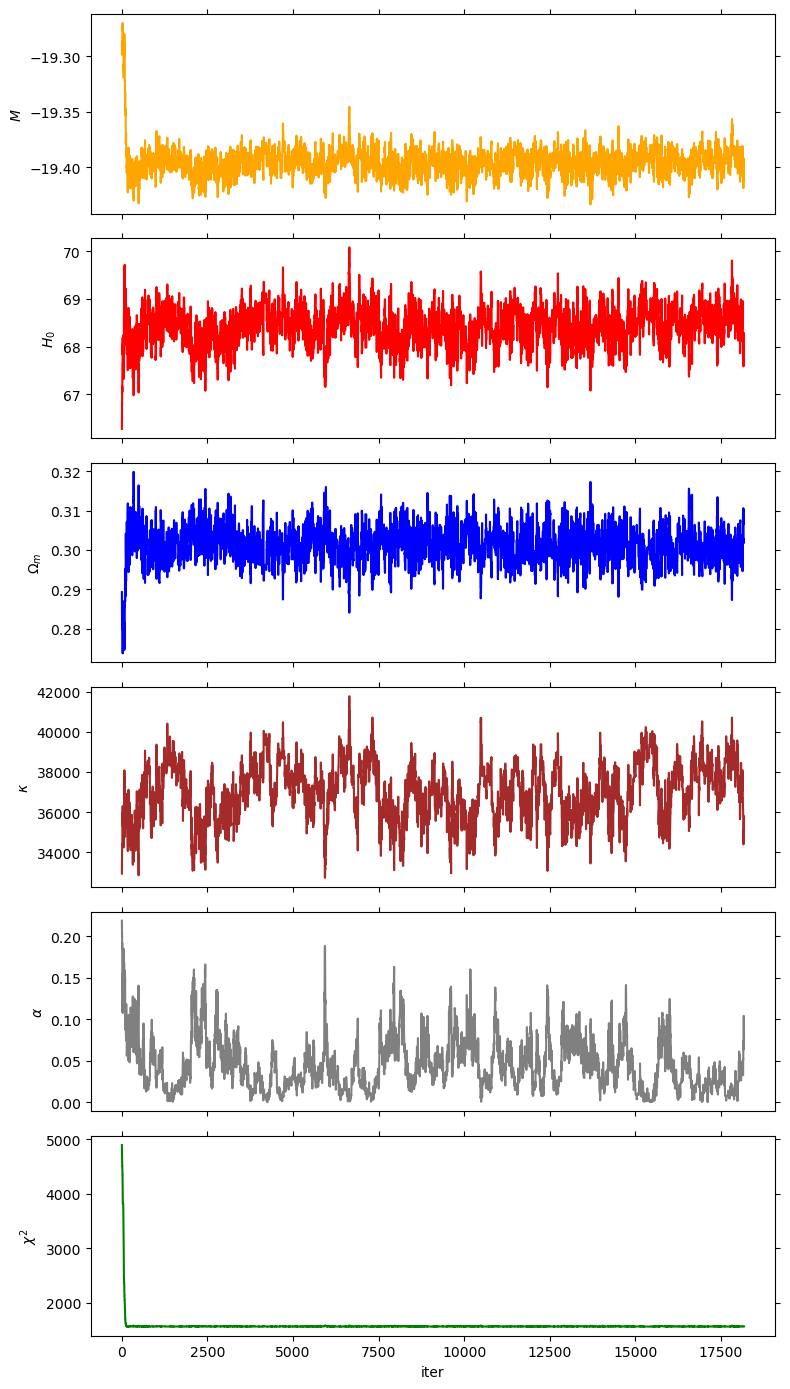

In [6]:
fig, ax = plt.subplots(nrows=6,ncols=1,sharex=True)
fig.set_size_inches(8, 14)

ax[0].plot(mcdata['M'], 'orange',label='$M$')
#ax[0].set_xlabel("iter")
ax[0].set_ylabel("$M$")
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')

ax[1].plot(mcdata['H0'], 'red',label='$H_0$')
#ax[1].set_xlabel("iter")
ax[1].set_ylabel("$H_0$")
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')

ax[2].plot(mcdata['Om'], 'blue',label='$\Omega_m$')
ax[2].set_ylabel("$\Omega_m$")
ax[2].yaxis.set_ticks_position('both')
ax[2].xaxis.set_ticks_position('both')

ax[3].plot(mcdata['k'], 'brown',label='$\kappa$')
ax[3].set_ylabel("$\kappa$")
ax[3].yaxis.set_ticks_position('both')
ax[3].xaxis.set_ticks_position('both')

ax[4].plot(mcdata['alpha'], 'gray',label='$\alpha$')
ax[4].set_ylabel("$\\alpha$")
ax[4].yaxis.set_ticks_position('both')
ax[4].xaxis.set_ticks_position('both')

ax[5].plot(mcdata['chi'], 'green',label='$chi$')
ax[5].set_xlabel("iter")
ax[5].set_ylabel("$\chi^2$")
#ax[3].set_yscale('log')
ax[5].yaxis.set_ticks_position('both')
ax[5].xaxis.set_ticks_position('both')

plt.tight_layout()
plt.show()

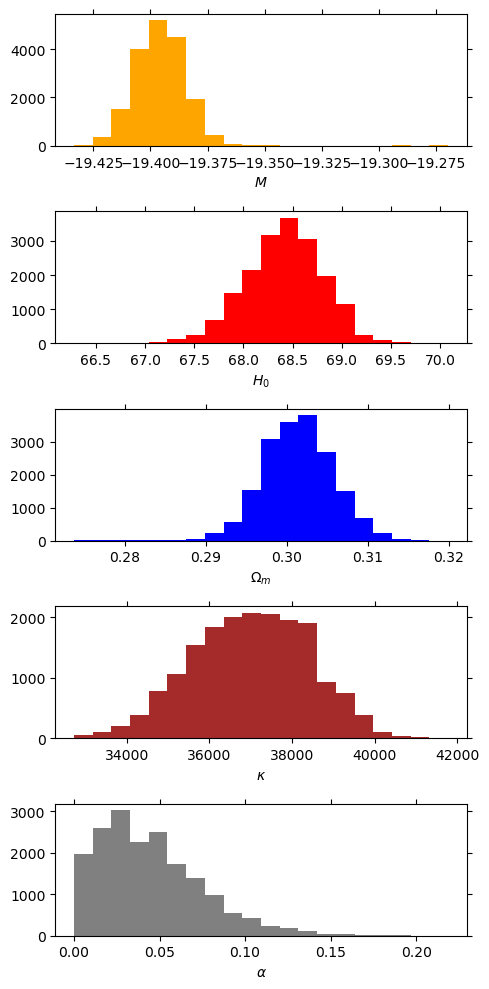

In [8]:
fig, ax = plt.subplots(nrows=5,ncols=1,sharex=False)
fig.set_size_inches(5, 10)

nbins = 20

ax[0].hist(mcdata['M'],bins = nbins,color='orange')
ax[0].set_xlabel("$M$")
ax[0].yaxis.set_ticks_position('both')
ax[0].xaxis.set_ticks_position('both')

ax[1].hist(mcdata['H0'],bins = nbins,color='red')
ax[1].set_xlabel("$H_0$")
ax[1].yaxis.set_ticks_position('both')
ax[1].xaxis.set_ticks_position('both')

ax[2].hist(mcdata['Om'],bins = nbins,color='blue')
ax[2].set_xlabel("$\Omega_m$")
ax[2].yaxis.set_ticks_position('both')
ax[2].xaxis.set_ticks_position('both')

ax[3].hist(mcdata['k'],bins = nbins,color='brown')
ax[3].set_xlabel("$\kappa$")
ax[3].yaxis.set_ticks_position('both')
ax[3].xaxis.set_ticks_position('both')

ax[4].hist(mcdata['alpha'],bins = nbins,color='gray')
ax[4].set_xlabel("$\\alpha$")
ax[4].yaxis.set_ticks_position('both')
ax[4].xaxis.set_ticks_position('both')

plt.tight_layout()
plt.show()

In [9]:
# Find the upper and lower limit under minimum 68% of confidence level
def error(boxin,hist):
    
    box_len = boxin[1]-boxin[0]
    boxes = np.zeros(len(hist))
    for idx in range(len(boxin)-1):
        boxes[idx] = 0.5*(boxin[idx+1]+boxin[idx])
    surf = (box_len*hist).sum()
        
    count = 0
    P = 0.99*hist.max()
    sigma = 0
    
    while sigma <0.683:
        count = count+1
        if count == 10000:
            break
        for idx in range(1,len(hist)):
            if hist[idx]>P:
                xa = boxes[idx-1]
                break
        for idx in range(1,len(hist)):
            if hist[-idx]>P:
                xb = boxes[-idx-1]
                break
        if xa<xb:
            surf_sig = (box_len*(hist*(boxes>xa)*(boxes<xb))).sum()
        else:
            surf_sig = (box_len*(hist*(boxes<xa)*(boxes>xb))).sum()
        sigma = surf_sig/surf
        P = 0.99*P
    return xa, xb, sigma

In [10]:
M_count, M_pos = np.histogram(mcdata['M'],bins = nbins)
M_best = M_pos[int(np.where(M_count == np.max(M_count))[0])] # most obtained value

H0_count, H0_pos = np.histogram(mcdata['H0'],bins = nbins)
H0_best = H0_pos[int(np.where(H0_count == np.max(H0_count))[0])] # most obtained value

Om_count, Om_pos = np.histogram(mcdata['Om'],bins = nbins)
Om_best = Om_pos[int(np.where(Om_count == np.max(Om_count))[0])] # most obtained value

alpha_count, alpha_pos = np.histogram(mcdata['alpha'],bins = nbins)
alpha_best = alpha_pos[int(np.where(alpha_count == np.max(alpha_count))[0])] # most obtained value


M1, M2, M_sigma = error(M_pos, M_count)
print('Best M:', M_best, '+',M2-M_best, '-', M_best-M1, ', confidence rate:',M_sigma,'\n')

Om1, Om2, Om_sigma = error(Om_pos, Om_count)
print('Best Omegam:', Om_best, '+',Om2-Om_best, '-', Om_best-Om1, ', confidence rate:',Om_sigma,'\n')

H01, H02, H0_sigma = error(H0_pos, H0_count)
print('Best H0:', H0_best, '+',H02-H0_best, '-', H0_best-H01, ', confidence rate:',H0_sigma,'\n')

alpha1, alpha2, alpha_sigma = error(alpha_pos, alpha_count)
print('Best alpha:', alpha_best, '+',alpha2-alpha_best, '-', alpha_best-alpha1, ', confidence rate:',alpha_sigma,'\n')

Best M: -19.400761859025607 + 0.020470498561543593 - 0.02047049856154004 , confidence rate: 0.8367537826685008 

Best Omegam: 0.3014105682881793 + 0.005772206054794615 - 0.008081088476712517 , confidence rate: 0.8096836313617605 

Best H0: 68.36896974983377 + 0.47559724410889714 - 0.6658361417524503 , confidence rate: 0.7440990371389273 

Best alpha: 0.021862129846467456 + 0.060100471766236216 - 0.016391037754428062 , confidence rate: 0.7458046767537826 



## GetDist

In [12]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
import pandas as pd
import numpy as np
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

GetDist Version: 1.4.8, Matplotlib version: 3.7.1


In [13]:
Lambda = pd.read_csv('mc10000PBH.txt', sep='\t', header=0)
Peebles = mcdata
PANT_mcdata = mcdata
ndim=3
names1 = ['w_m','alpha','k']
names2 = ['M','H0','Om']
labels1 = ['\omega_m','\\alpha','\\bar\kappa']
labels2 = ['M','H_0','\Omega_m']
samples1 = MCSamples(samples=[np.array(Peebles['w_m']),
                              np.array(Peebles['alpha']),
                              np.array(Peebles['k'])],
                     names = names1, labels = labels1,
                     ranges = {'w_m':(0.09,0.15),'alpha':(0.,2.),'k':(20000.,50000.)})
                     
samples2 = MCSamples(samples=[np.array(Peebles['M']),
                              np.array(Peebles['H0']),
                              np.array(Peebles['Om'])],
                      names = names2, labels = labels2)
samples3 = MCSamples(samples=[np.array(Lambda['M']),
                              np.array(Lambda['H0']),
                              np.array(Lambda['Om'])],
                      names = names2, labels = labels2)

Removed no burn in
Removed no burn in
Removed no burn in


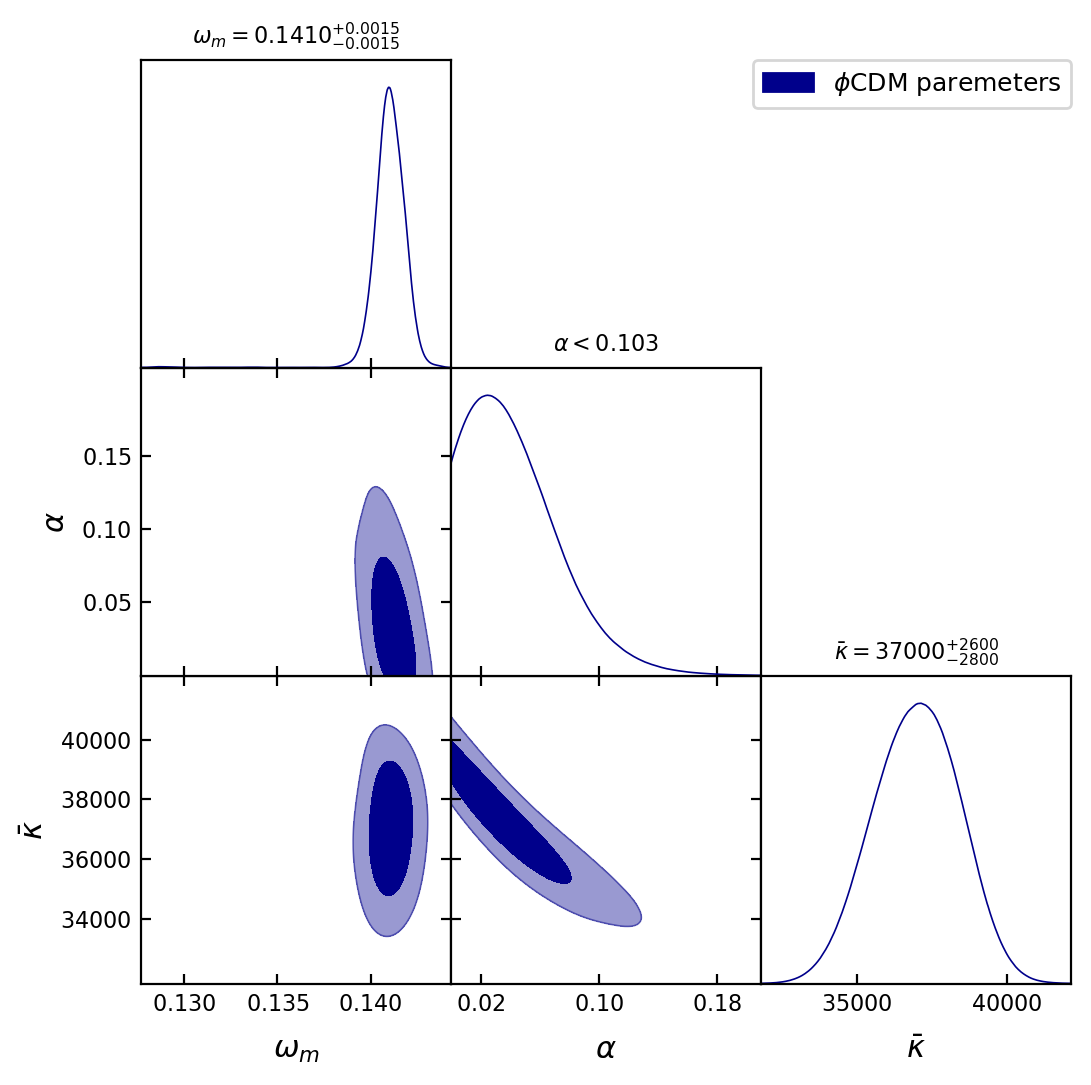

In [14]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples1], filled=True,
                contour_colors=['darkblue'],
                title_limit=2, legend_labels=['$\phi$CDM paremeters'])
g.export('phiCDM_parameters.pdf')

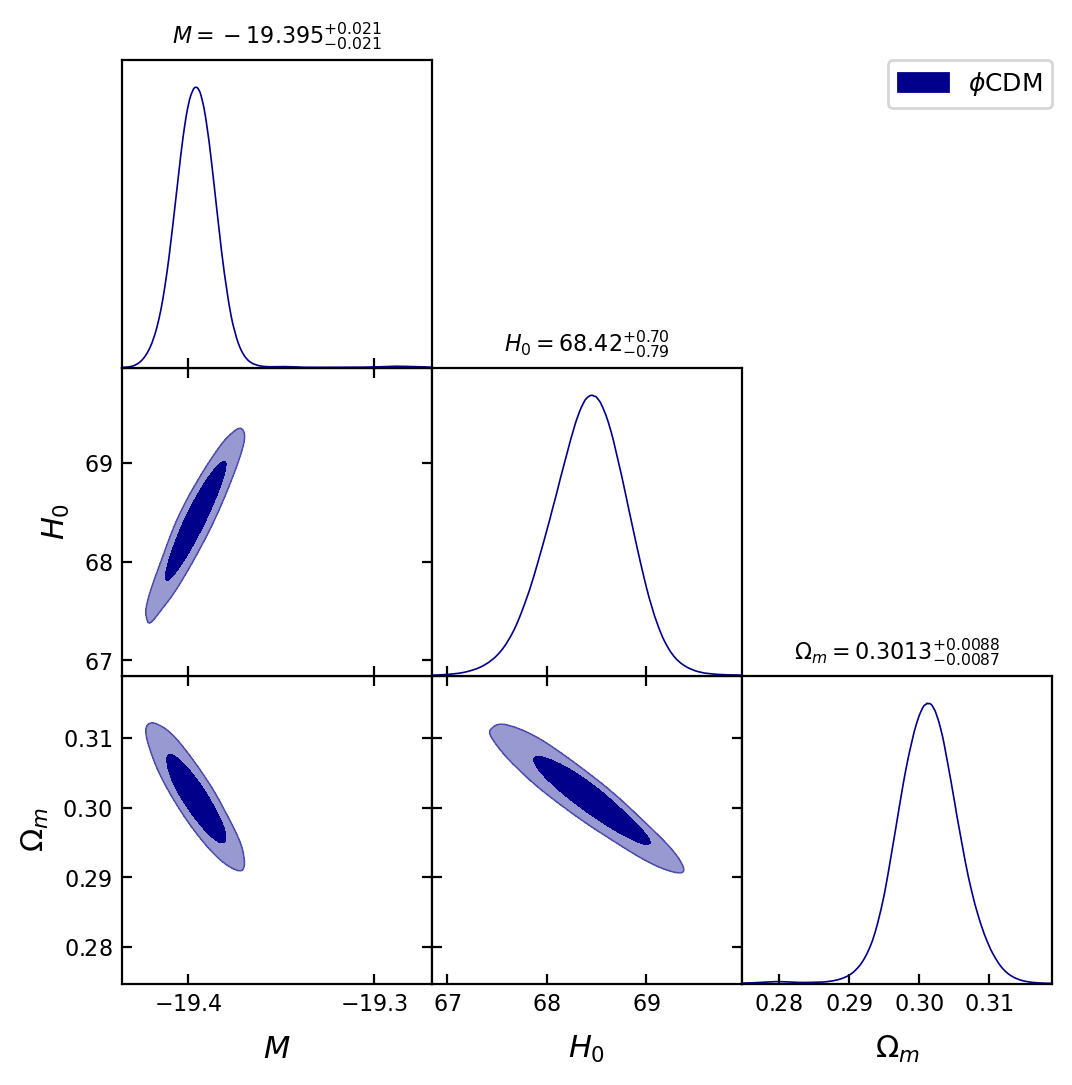

In [15]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples2], filled=True,
                contour_colors=['darkblue'],
                title_limit=2, legend_labels=['$\phi$CDM'])
g.export('phiCDM_HMO.pdf')

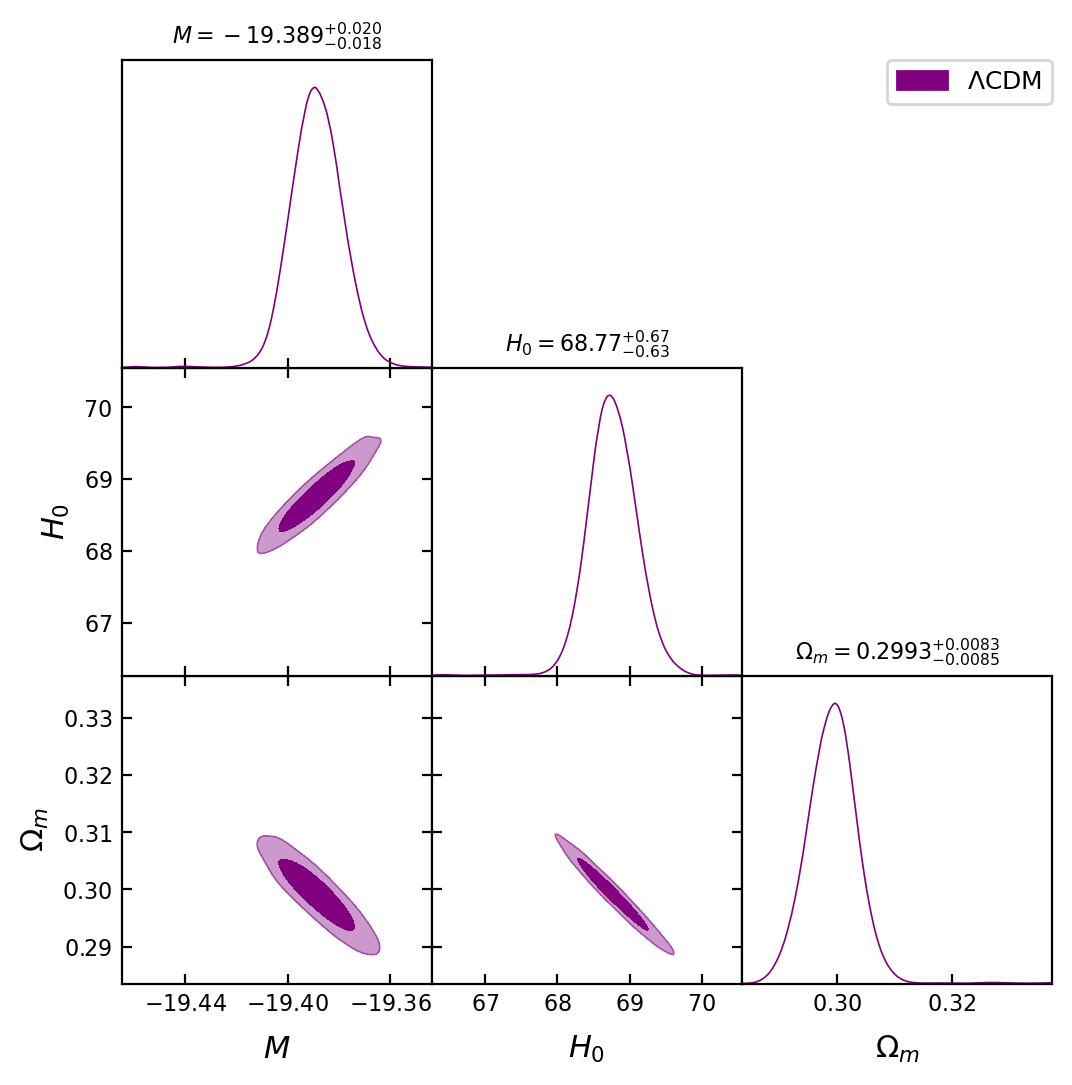

In [16]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples3], filled=True,
                contour_colors=['purple'],
                title_limit=2, legend_labels=['$\Lambda$CDM'])
g.export('lambdaCDM_HMO.pdf')

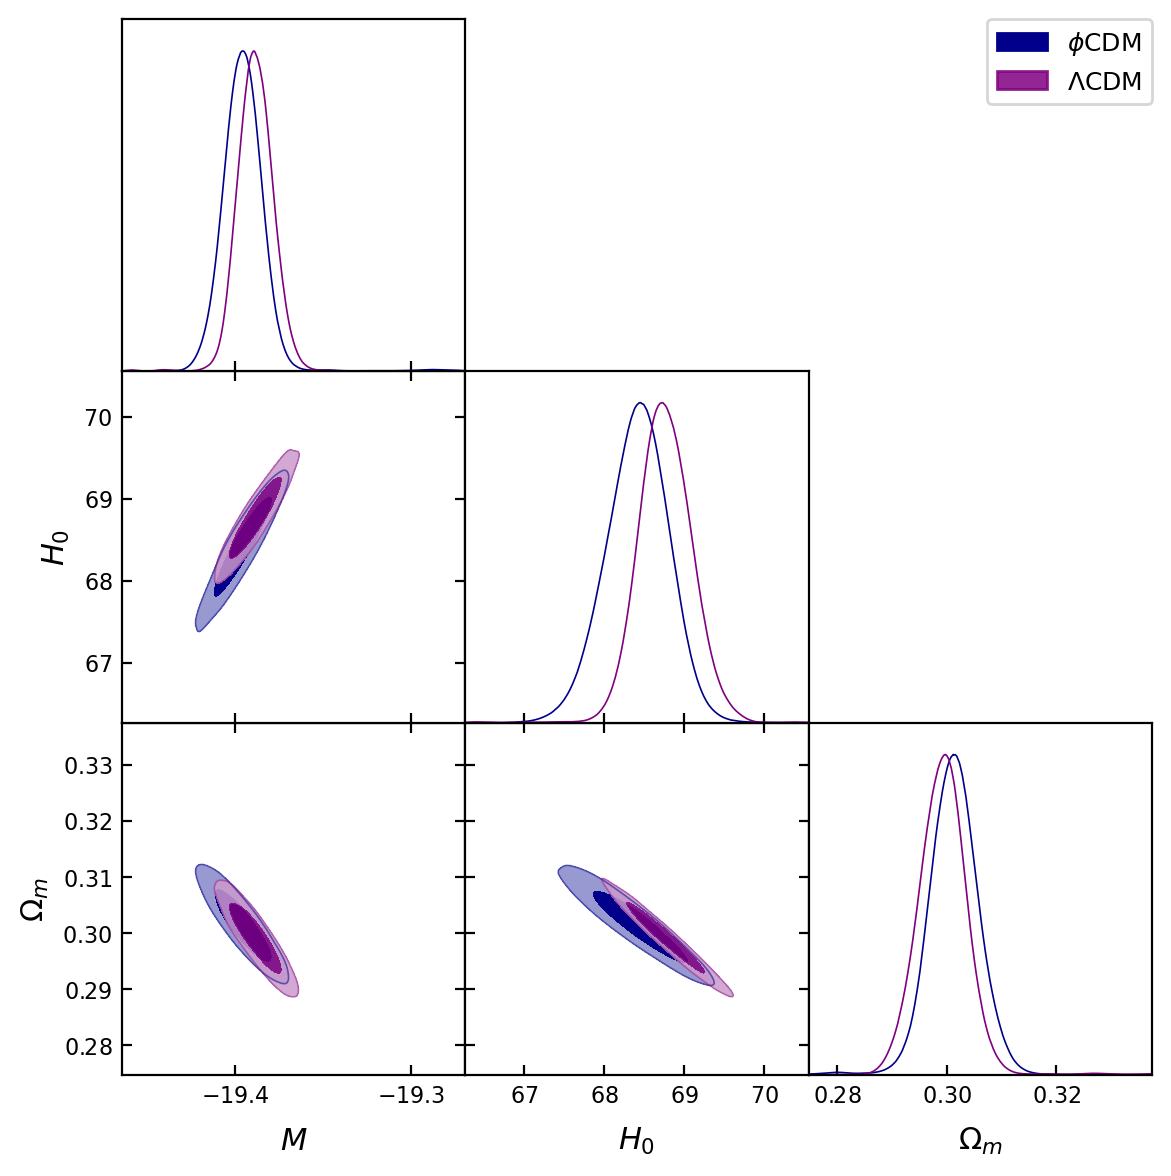

In [17]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples2,samples3], filled=True,
                contour_colors=['darkblue','purple'],
                title_limit=0, legend_labels=['$\phi$CDM','$\Lambda$CDM'])
g.export('phi_lambda_compare.pdf')

-----